In [57]:
# Data collection and Manipulation
import pandas as pd
import numpy as np
import yfinance as yf

# Eda and visualization 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

# Decomposition models
from statsmodels.tsa.seasonal import seasonal_decompose

# perameter tunning 
from pmdarima import auto_arima

from statsmodels.tsa.stattools import acf

from sklearn.model_selection import TimeSeriesSplit


In [19]:
# Import data set from yahoo finance 
ticker = "AAPL"
df = yf.download(ticker, start="2015-01-01", end="2024-12-31", progress=False)


# make the data columns single dimentional
df.columns = ['_'.join(col).strip() for col in df.columns.values]

# Check the new columns
print(df.columns)

# Print the first 10 Lines of dataset 
df.head(10)

Index(['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL'], dtype='str')


,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
Date,,,,,
2015-01-02,24.214891,24.682224,23.776352,24.671149,212818400
2015-01-05,23.532728,24.064291,23.346682,23.984557,257142000
2015-01-06,23.534933,23.794069,23.173912,23.596948,263188400
2015-01-07,23.864954,23.964621,23.632395,23.743137,160423600
2015-01-08,24.781891,24.839477,24.075355,24.192743,237458000
2015-01-09,24.808472,25.083112,24.409799,24.954651,214798000
2015-01-12,24.197174,24.945791,24.097507,24.939147,198603200
2015-01-13,24.412012,24.983442,24.121868,24.680008,268367600
2015-01-14,24.318995,24.471818,24.031064,24.150666,195826400


In [20]:
monthly_close_mean = df.resample('ME').mean()
monthly_close_mean.head()

,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
Date,,,,,
2015-01-31,24.505370,24.862514,24.215336,24.621096,2.610527e+08
2015-02-28,27.874482,28.032853,27.563169,27.783748,2.392706e+08
2015-03-31,28.010708,28.336564,27.791685,28.120877,2.070258e+08
2015-04-30,28.304337,28.555814,28.067155,28.358551,1.897401e+08
2015-05-31,28.727202,28.952265,28.482188,28.715059,1.908304e+08


In [21]:
if isinstance(df, pd.DataFrame):
    print("df is a pandas DataFrame")
else:
    print("df is not a pandas DataFrame")

df is a pandas DataFrame


In [22]:
### Funciton to display data informaiton

def Columns_Info(df):
    """
    Display a detailed table showing:
    - Number of unique values per column
    - Number of null values
    - Data type
    - Total rows, total columns, count of each data type
    """
    # Column-wise info
    unique_counts = {
        "Column": df.columns,
        "Unique Values": [df[col].nunique() for col in df.columns],
        "Null Values": [df[col].isna().sum() for col in df.columns],
        "Data Type": [df[col].dtype for col in df.columns]
    }
    result_df = pd.DataFrame(unique_counts)
    
    # Overall info
    total_rows = df.shape[0]
    total_cols = df.shape[1]
    dtype_counts = df.dtypes.value_counts().to_dict()
    
    # Display
    print(f"Total Rows: {total_rows}")
    print(f"Total Columns: {total_cols}")
    print("Column types count:", dtype_counts)
    print("-"*50)
    display(result_df)

In [23]:
Columns_Info(df)

Total Rows: 2515
Total Columns: 5
Column types count: {dtype('float64'): 4, dtype('int64'): 1}
--------------------------------------------------


,Column,Unique Values,Null Values,Data Type
0,Close_AAPL,2481,0,float64
1,High_AAPL,2515,0,float64
2,Low_AAPL,2515,0,float64
3,Open_AAPL,2515,0,float64
4,Volume_AAPL,2508,0,int64


In [24]:
duplicate_check = df.index.duplicated().sum()

if duplicate_check == 0:
    print("✅ No duplicate timestamps found in the dataset.")
else:
    print(f"⚠️ Dataset contains {duplicate_check} duplicate timestamps.")

✅ No duplicate timestamps found in the dataset.


Since this dataset has not any missing value, duplicate values and also it contain all features in relative format so it looks clean dataset.

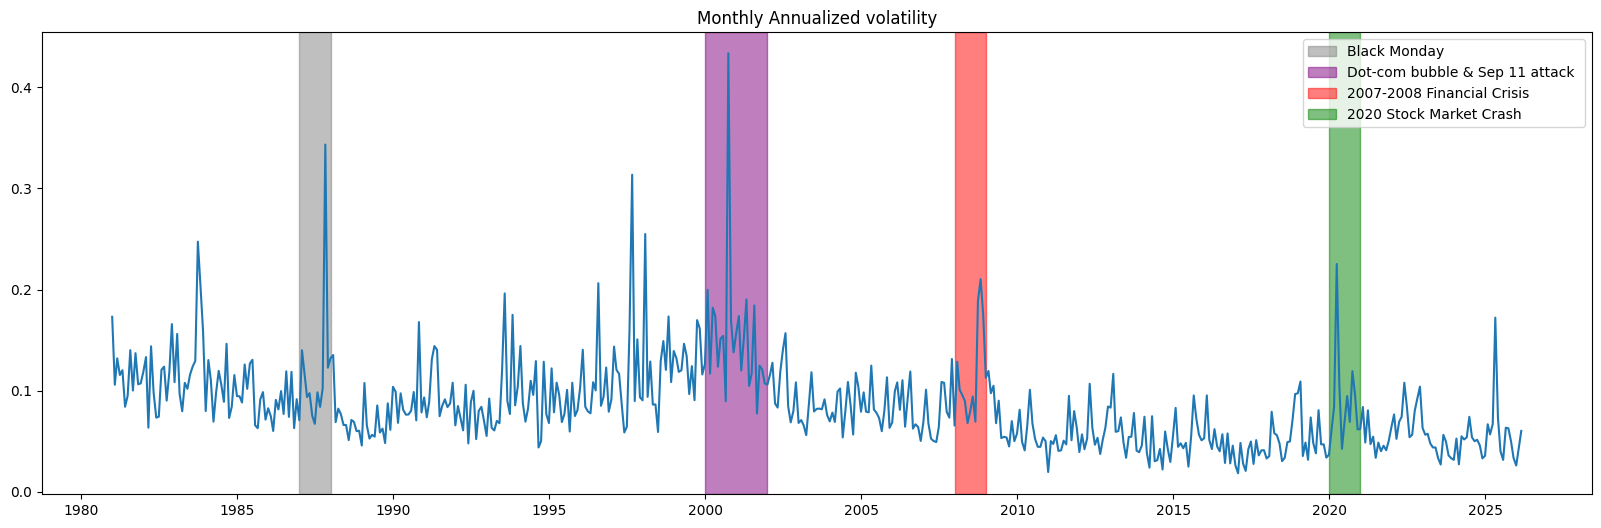

In [25]:
df_all = yf.download(ticker, start="1900-01-01", end="2026-12-31", progress=False)

df_all.columns = ['_'.join(col).strip() for col in df_all.columns.values]


#To model returns we will use daily % change
daily = df_all['Close_AAPL'].pct_change()
daily.dropna(inplace = True)

#Resample returns per month and take STD as measure of volatility
monthly=daily.resample("ME").std()*np.sqrt(12)

import matplotlib.patches as mpatches

#Visulize major market events show up in the volatility
plt.figure(figsize=(20, 6))
plt.plot(monthly)
plt.axvspan('1987','1988',color='grey',alpha=.5)
plt.axvspan('2000','2002',color='purple',alpha=.5)
plt.axvspan('2008','2009',color='r',alpha=.5)
plt.axvspan('2020','2021',color='g',alpha=.5)
plt.title("Monthly Annualized volatility")
l1=mpatches.Patch(color='grey',alpha=.5, label="Black Monday")
l2=mpatches.Patch(color='purple',alpha=.5, label="Dot-com bubble & Sep 11 attack ")
l3=mpatches.Patch(color='red',alpha=.5, label="2007-2008 Financial Crisis")
l4=mpatches.Patch(color='green',alpha=.5, label="2020 Stock Market Crash")
plt.legend(handles=[l1,l2,l3,l4])

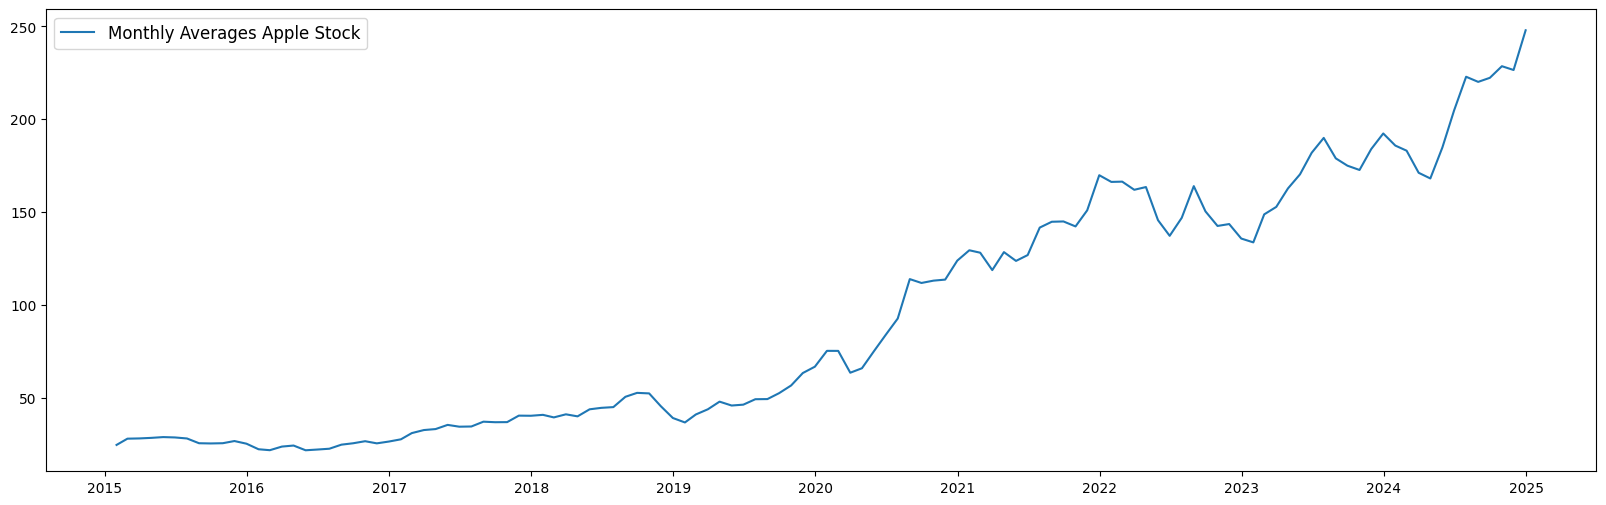

In [41]:
# Resample the data to the monthly level
monthly_close_mean = df['Close_AAPL'].resample('ME').mean()
monthly_close_mean = monthly_close_mean.to_frame()
##Monthly Stock Price 
fig = plt.figure(figsize=(20,6))
plt.plot(monthly_close_mean
['Close_AAPL'],label='Monthly Averages Apple Stock')
plt.legend(prop={'size': 12})
plt.show()

### Decomposition

In [27]:
# df = px.data.stocks()
fig = px.line(monthly_close_mean, x= monthly_close_mean.index, y="Close_AAPL")
fig.show()

Let's use a statistical test to determine whether this series follows an additive or multiplicative pattern, so we can make more informed decisions.

In [28]:
# 1. Resample yearly mean and std dev
yearly = monthly_close_mean.resample('YE').agg(['mean', 'std'])

# 2. Correlation between mean and std
correlation = yearly['mean'].corr(yearly['std'])

print(f'Correlation between yearly mean and std dev: {correlation:.2f}')

Correlation between yearly mean and std dev: 0.86


**as we have 0.87 ~ 1. as output we can say that this series is multiplicative so let's decompose this with multiplicative model.**

In [29]:
# Perform multiplicative seasonal decomposition
decomposition = seasonal_decompose(monthly_close_mean, model='multiplicative')

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot with Plotly subplots
fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=("Observed Data", "Trend", "Seasonal", "Residual")
)

fig.add_trace(go.Scatter(x=observed.index, y=observed, mode='lines', name='Observed', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=trend.index, y=trend, mode='lines', name='Trend', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=seasonal.index, y=seasonal, mode='lines', name='Seasonal', line=dict(color='green')), row=3, col=1)
fig.add_trace(go.Scatter(x=residual.index, y=residual, mode='lines', name='Residual', line=dict(color='red')), row=4, col=1)

fig.update_layout(
    title="Seasonal Decomposition of AAPL Monthly Close Price",
    height=900,
    showlegend=False,
    template='plotly_white'
)
fig.show()

In [30]:
fig = px.histogram(
    monthly_close_mean,
    x='Close_AAPL',
    nbins=30,
    title='Distribution of AAPL Closing Prices'
)
fig.update_layout(
    xaxis_title='Close Price',
    yaxis_title='Count',
    bargap=0.1
)
fig.show()

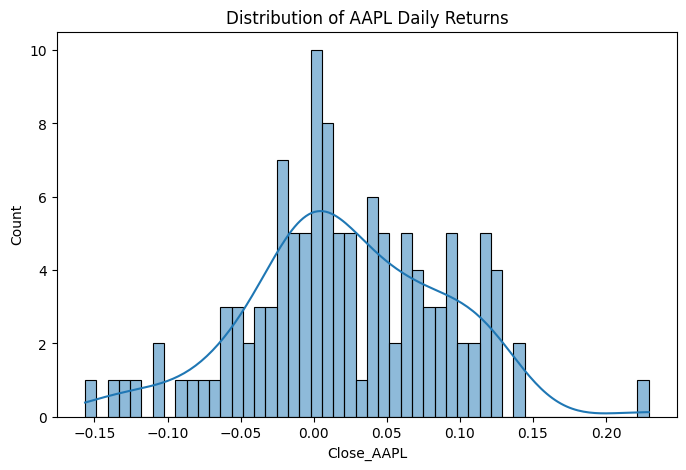

In [31]:
plt.figure(figsize=(8,5))
monthly_close_mean['Returns_AAPL'] = monthly_close_mean.pct_change()
sns.histplot(monthly_close_mean['Returns_AAPL'].dropna(), bins=50, kde=True)
plt.title('Distribution of AAPL Daily Returns')
plt.show()

## Autocorrelation Function (ACF)


## How to interpret the ACF plot?

Lag 0 autocorrelation is always 1: This represents the series correlated with itself and is not interpreted.       

Rapid decay toward zero indicates weak temporal dependence, meaning past values have limited influence on future values.      

Slow decay (autocorrelation remains high across many lags) indicates strong dependence, often caused by trend, seasonality, or smooth underlying dynamics.    

Confidence bands:
- Bars inside the shaded area are not statistically significant.
- Bars outside the shaded area indicate statistically significant autocorrelation.






In [35]:
monthly_close_mean.head()

Date
2015-01-31 00:00:00     24.50537
2015-02-28 00:00:00    27.874482
2015-03-31 00:00:00    28.010708
2015-04-30 00:00:00    28.304337
2015-05-31 00:00:00    28.727202
Name: Close_AAPL, dtype: object

<Figure size 1000x400 with 0 Axes>

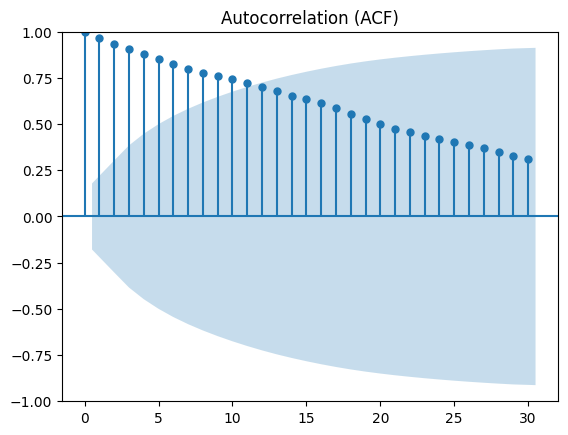

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(10,4))
plot_acf(monthly_close_mean['Close_AAPL'].dropna(), lags=30)
plt.title('Autocorrelation (ACF)')
plt.show()

## Partial Correlation (PACF)

### How to interpret the PACF plot: 
 
Lag 0 is always equal to 1, since the series is perfectly correlated with itself.     

A spike at lag k means the value from k steps back has a direct influence on the current value.   

If only the first few lags stand out, the series is mainly driven by recent past values.      

A gradual fade across lags suggests that most relationships are indirect and shaped by smooth changes or seasonality, rather than strong direct effects at many lags. 

<Figure size 1000x400 with 0 Axes>

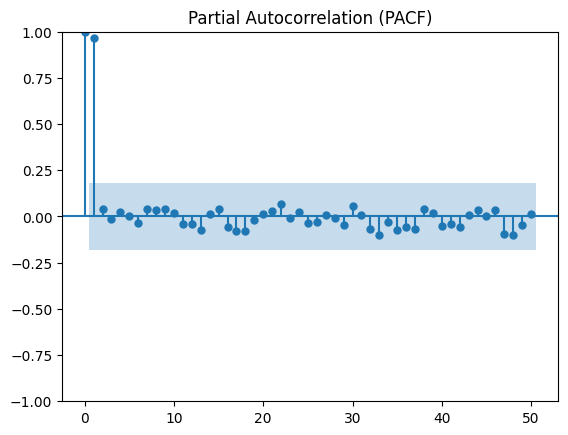

In [44]:
plt.figure(figsize=(10,4))
plot_pacf(monthly_close_mean['Close_AAPL'].dropna(), lags=50)
plt.title('Partial Autocorrelation (PACF)')
plt.show()  

## Analyze stationarity of the time series

In [45]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_close_mean["Close_AAPL"])
labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations']

for value, label in zip(result, labels):
    print(f"{label}: {value}")

if result[1] <= 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Test Statistic: 1.495312017749654
p-value: 0.9975068919692093
#Lags Used: 9
Number of Observations: 110
Data is not stationary


### Differencing

In [46]:
df_diff = pd.DataFrame()
df_diff["Close_AAPL"] = monthly_close_mean["Close_AAPL"].diff().dropna()
# If you gonna need to apply second-order differencing you need to change order 1 to 2.

In [47]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_diff['Close_AAPL'])
labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations']

for value, label in zip(result, labels):
    print(f"{label}: {value}")

if result[1] <= 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Test Statistic: -3.353393852827303
p-value: 0.012654064818481815
#Lags Used: 8
Number of Observations: 110
Data is stationary


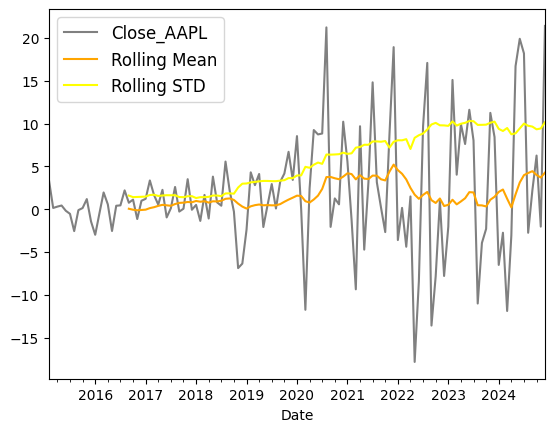

In [48]:
##Differencing By 1
monthly_diff = monthly_close_mean['Close_AAPL'] - monthly_close_mean['Close_AAPL'].shift(1)
monthly_diff[1:].plot(c='grey')
monthly_diff[1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
monthly_diff[1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

In [49]:
modelling_series = monthly_close_mean['Close_AAPL']
from sklearn.model_selection import train_test_split as split
train,test = split(modelling_series,train_size=0.6,shuffle=False)

In [54]:
modelling_series.head()

Date
2015-01-31    24.505370
2015-02-28    27.874482
2015-03-31    28.010708
2015-04-30    28.304337
2015-05-31    28.727202
Freq: ME, Name: Close_AAPL, dtype: float64

In [53]:
isinstance(modelling_series, pd.Series)

True

In [ ]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

list_param = []
list_param_seasonal = []
list_results_aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            print(f'ARIMA{param}x{param_seasonal}12 - AIC:{results.aic:.2f}')

            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic)

        except Exception as e:
            print(f"Skipped ARIMA{param}x{param_seasonal}12 due to {e}")
            continue


In [137]:
import statsmodels.api as sm
def backtest_model(train,test, dataset_no):
    model = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2,2,0,12))
    results=model.fit()

    forecasts_train = results.predict(start=0,end=len(train))
    forecasts_test = results.predict(start=len(train),end=len(train)+len(test))


    fig,(ax1,ax2) = plt.subplots(2,figsize=(12,4))

    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    forecasts_train = pd.DataFrame(forecasts_train)
    forecasts_test = pd.DataFrame(forecasts_test)

    forecasts_train.plot(label='Forecasts',ax=ax1,title=f'SARIMA Forecasting -Train Data Set - {dataset_no}')
    train.plot(label='Actual',ax=ax1)
    ax1.set_ylabel('Stock Price')
    ax1.set_xlabel('Time')

    forecasts_test.plot(label='Forecasts',ax=ax2,title=f'SARIMA Forecasting -Test Data Set - {dataset_no}')
    test.plot(label='Actual',ax=ax2)
    ax2.set_ylabel('Stock Price')
    ax2.set_xlabel('Time')

    ax1.legend()
    ax2.legend()
    plt.tight_layout(pad=2)

Observations: 60
Training Observations: 30
Testing Observations: 30
Observations: 90
Training Observations: 60
Testing Observations: 30
Observations: 120
Training Observations: 90
Testing Observations: 30


<Figure size 640x480 with 0 Axes>

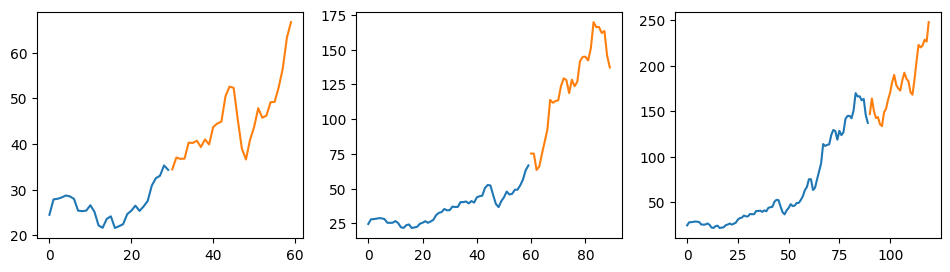

In [138]:
# Collect train/test sets as before
train_sets = []
test_sets = []

time_series_splits = TimeSeriesSplit(n_splits=3)
X = modelling_series.values

plt.figure(1)
fig = plt.figure(figsize=(24, 10))

index = 1
for train_index, test_index in time_series_splits.split(X):
    train = X[train_index]
    test = X[test_index]

    train_sets.append(train)
    test_sets.append(test)

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))

    plt.subplot(360 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])

    index += 1

plt.show()

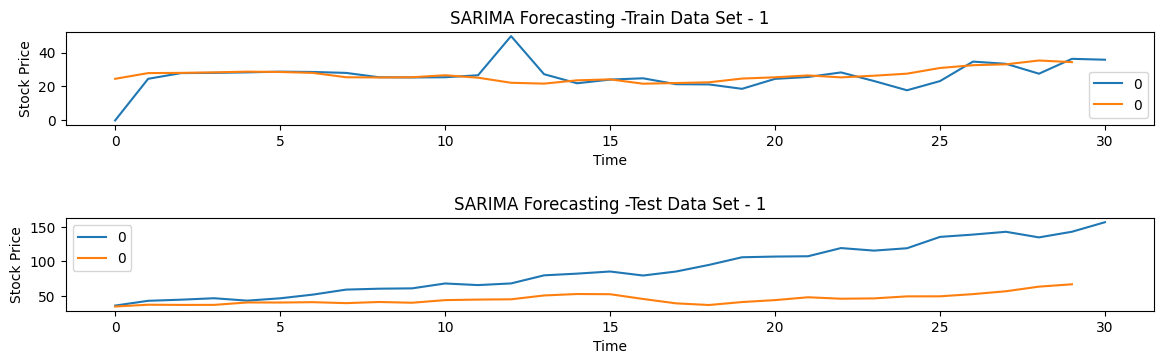

In [141]:
backtest_model(train_sets[0],test_sets[0], dataset_no=1)

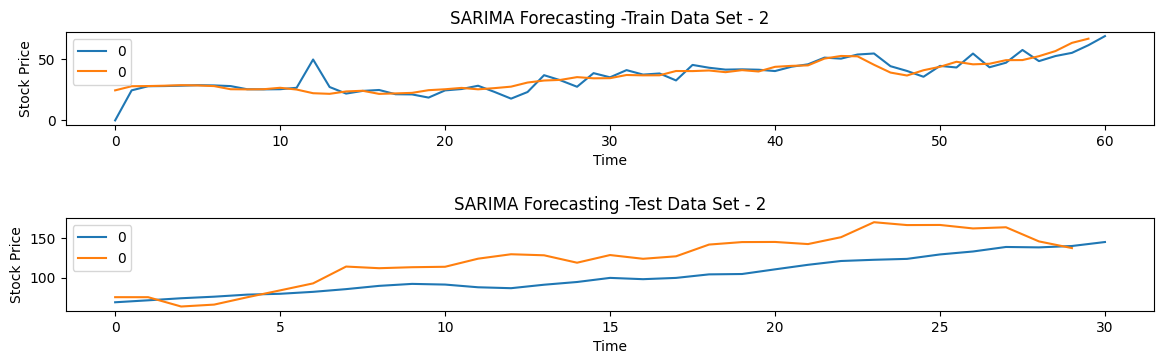

In [140]:
backtest_model(train_sets[1],test_sets[1], dataset_no=2)

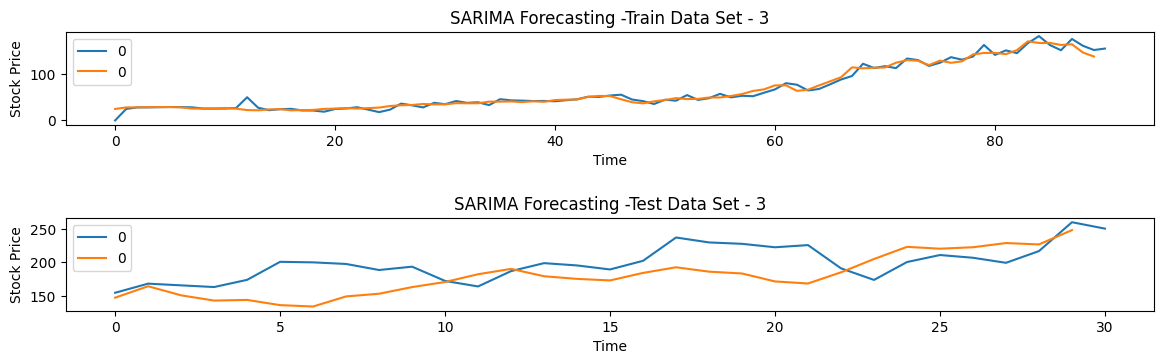

In [142]:
backtest_model(train_sets[2],test_sets[2], dataset_no=3)

In [149]:
print(type(modelling_series.index))
print(modelling_series.index)

<class 'pandas.DatetimeIndex'>
DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31',
               ...
               '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[s]', name='Date', length=120, freq='ME')


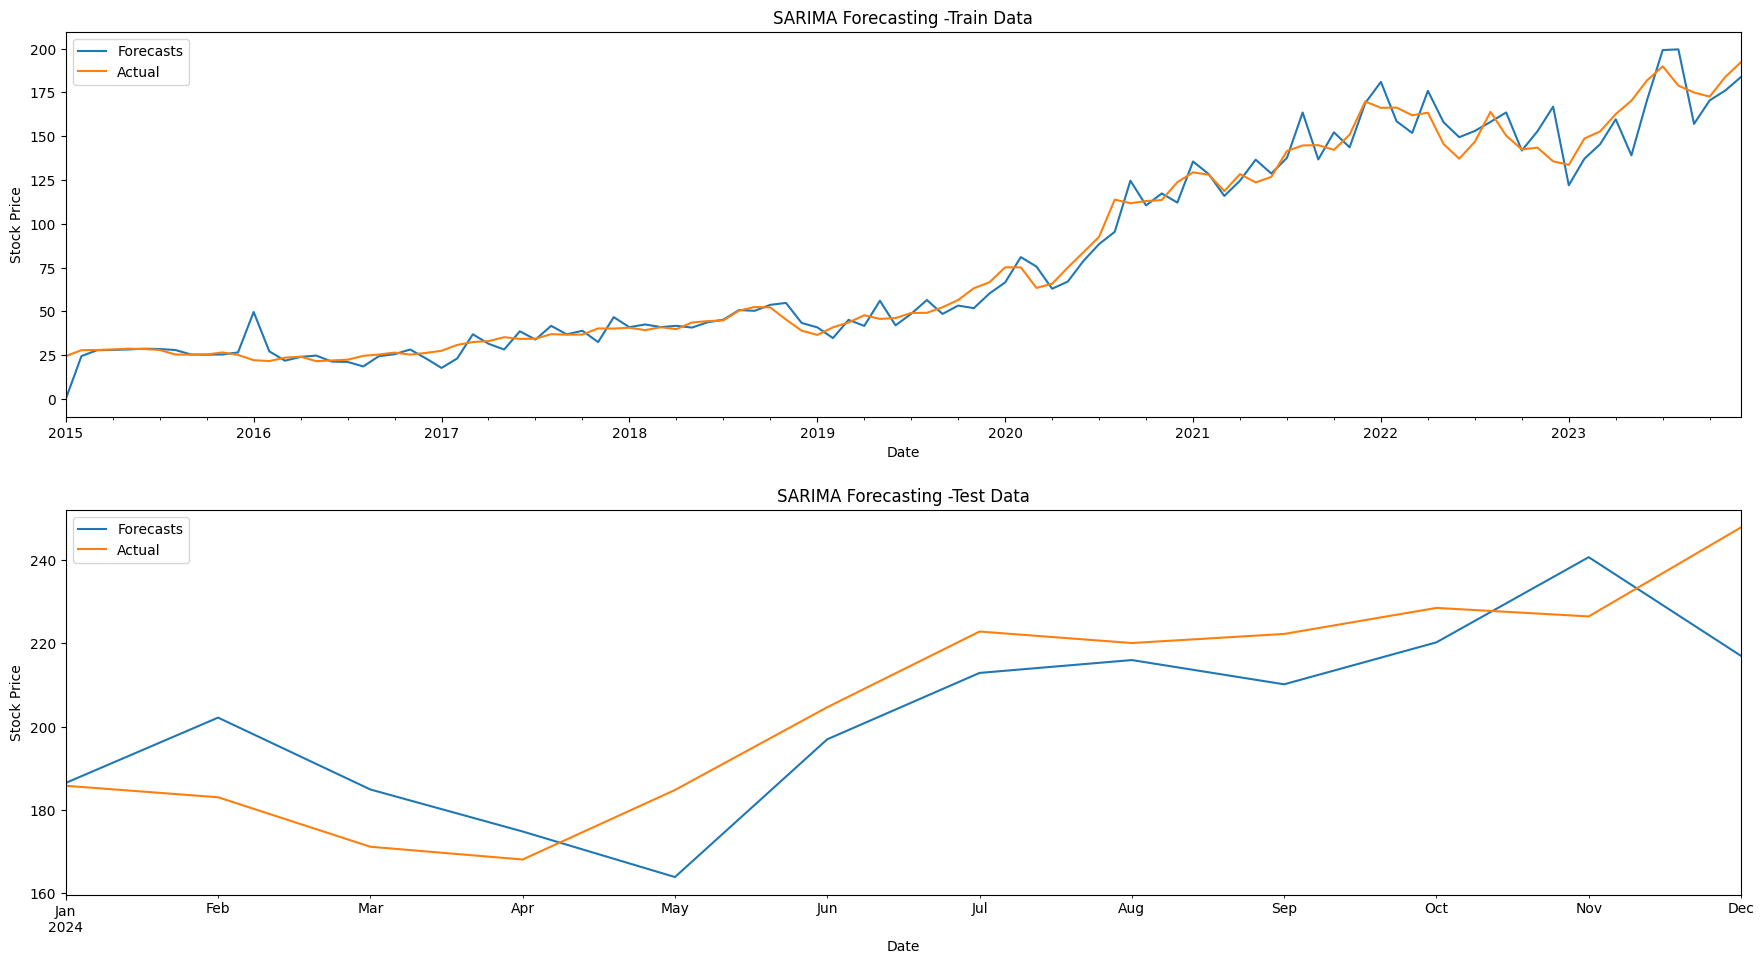

In [ ]:
model = sm.tsa.SARIMAX(modelling_series,order=(1,1,1),seasonal_order=(2,2,0,12))
results=model.fit()
forecasts_train = results.predict(start='2015-01-31', end='2023-12-31')
forecasts_test = results.predict(start='2024-01-31', end='2024-12-31')

sd = '2015-01-31'
ed = '2023-12-31'
sd2 = '2024-01-31'
ed2 = '2024-12-31'

fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
modelling_series.loc[sd:ed].plot(label='Actual',ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
modelling_series.loc[sd2:ed2].plot(label='Actual',ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)

In [159]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
##Function to Calculate Result Metrics
def result_metrics(test_series,forecast_series,model_name):
  print('Result Metrics for {}'.format(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))

print(result_metrics(modelling_series[sd:ed],forecasts_train,'SARIMA-Train Data'))
print('----')
print(result_metrics(modelling_series[sd2:ed2],forecasts_test,'SARIMA-Test Data'))

Result Metrics for SARIMA-Train Data
R2 Score :  0.974
Mean Squared Error :  82.11
Mean Absolute Error :  6.381
None
----
Result Metrics for SARIMA-Test Data
R2 Score :  0.654
Mean Squared Error :  215.549
Mean Absolute Error :  12.376
None


In [160]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          Close_AAPL   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(2, 2, [], 12)   Log Likelihood                -359.845
Date:                             Thu, 12 Feb 2026   AIC                            729.690
Time:                                     16:49:55   BIC                            742.459
Sample:                                 01-31-2015   HQIC                           734.850
                                      - 12-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1195      0.307     -0.389      0.697      -0.722       0.483
ma.L1          0.4721      